In [13]:
# STEP 0 — IMPORT LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

In [16]:
# STEP 1 — DATA UNDERSTANDING

# Load dataset
df = pd.read_csv("D:\\TakeHomeTest\\DS\Dataset\\Food_Delivery_Times.csv")

# Basic checks
print("Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)
print("\nSample Data:")
df.head()
print("\nDescribe Data:")
print(df.describe())

Shape: (1000, 9)

Data Types:
Order_ID                    int64
Distance_km               float64
Weather                    object
Traffic_Level              object
Time_of_Day                object
Vehicle_Type               object
Preparation_Time_min        int64
Courier_Experience_yrs    float64
Delivery_Time_min           int64
dtype: object

Sample Data:

Describe Data:
          Order_ID  Distance_km  Preparation_Time_min  Courier_Experience_yrs  \
count  1000.000000  1000.000000           1000.000000              970.000000   
mean    500.500000    10.059970             16.982000                4.579381   
std     288.819436     5.696656              7.204553                2.914394   
min       1.000000     0.590000              5.000000                0.000000   
25%     250.750000     5.105000             11.000000                2.000000   
50%     500.500000    10.190000             17.000000                5.000000   
75%     750.250000    15.017500             23.000000

In [17]:
#2 — Data Quality Check
# =========================================================
print("\n🔎 Cek Duplikasi:", df.duplicated().sum(), "rows")

print("\n📌 Missing Values:")
print(df.isnull().sum())


🔎 Cek Duplikasi: 0 rows

📌 Missing Values:
Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64


In [18]:
# 🔹 Handling Missing Values
categorical_cols = ['Weather', 'Traffic_Level', 'Time_of_Day']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

df['Courier_Experience_yrs'] = df['Courier_Experience_yrs'].fillna(df['Courier_Experience_yrs'].median())

print("\n📌 Missing Values Setelah Imputasi:")
print(df.isnull().sum())


📌 Missing Values Setelah Imputasi:
Order_ID                  0
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64


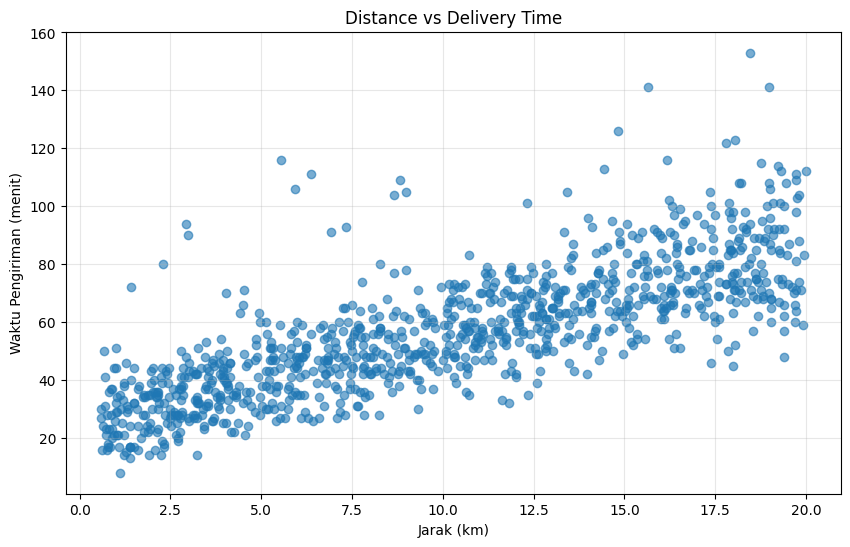

In [19]:
# 📊 4 — Exploratory Data Analysis

# Distance vs Delivery Time
plt.figure(figsize=(10, 6))
plt.scatter(df["Distance_km"], df["Delivery_Time_min"], alpha=0.6)
plt.title("Distance vs Delivery Time")
plt.xlabel("Jarak (km)")
plt.ylabel("Waktu Pengiriman (menit)")
plt.grid(alpha=0.3)
plt.show()

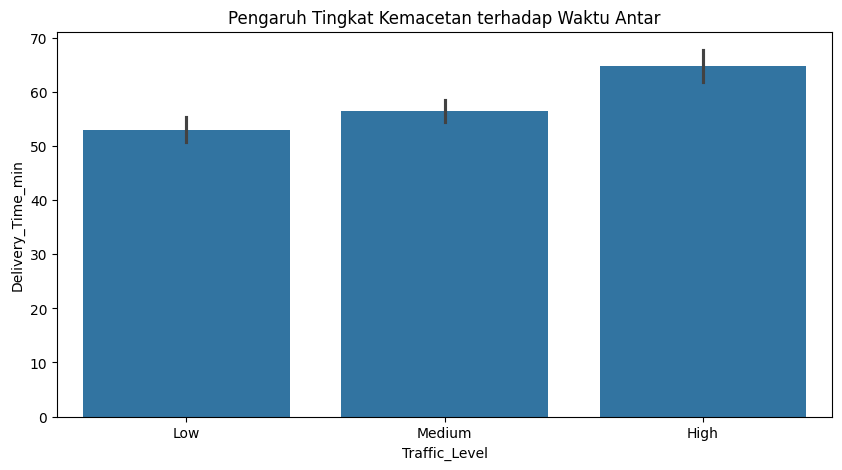

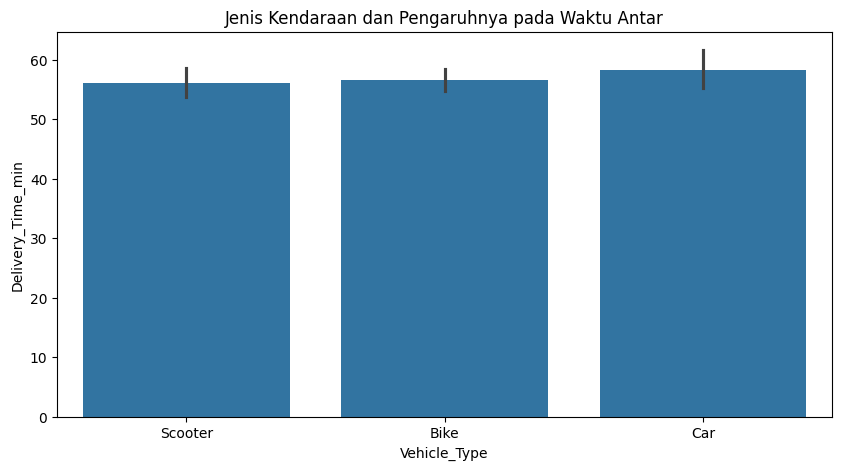

In [20]:
# Heatmap kategori terhadap delivery time
plt.figure(figsize=(10,5))
sns.barplot(x='Traffic_Level', y='Delivery_Time_min', data=df)
plt.title("Pengaruh Tingkat Kemacetan terhadap Waktu Antar")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x='Vehicle_Type', y='Delivery_Time_min', data=df)
plt.title("Jenis Kendaraan dan Pengaruhnya pada Waktu Antar")
plt.show()

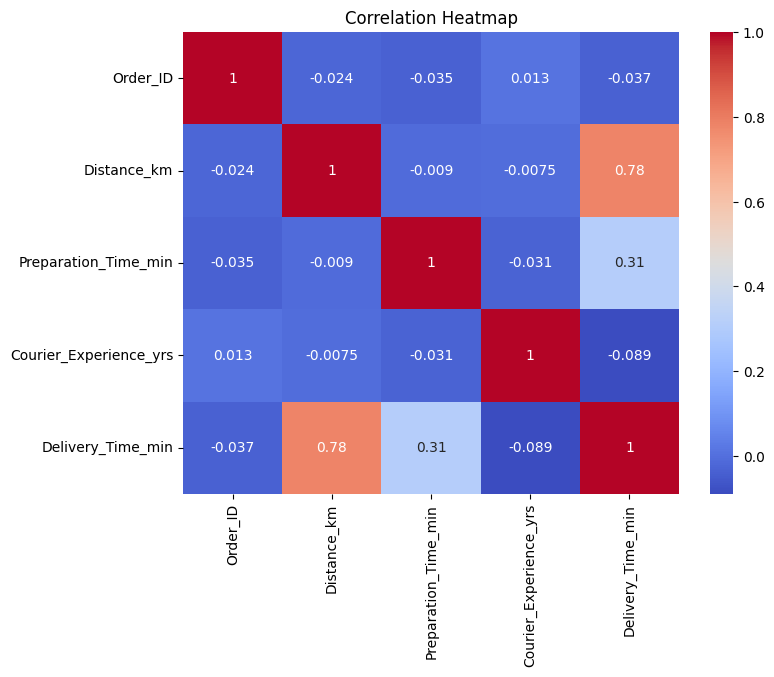

In [21]:
# Korelasi numerik
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

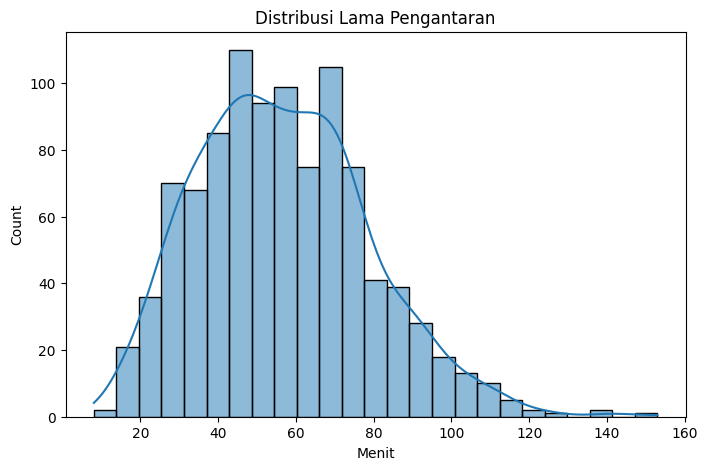

In [22]:
# ---- Distribusi Target ----
plt.figure(figsize=(8,5))
sns.histplot(df['Delivery_Time_min'], kde=True)
plt.title("Distribusi Lama Pengantaran")
plt.xlabel("Menit")
plt.show()

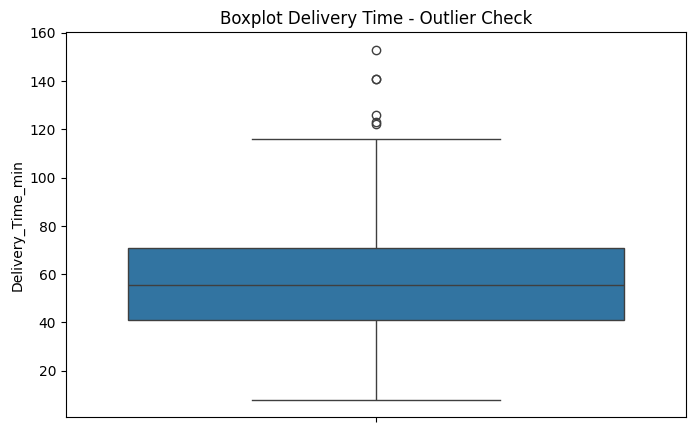

In [23]:
# ---- Outlier Detection ----
plt.figure(figsize=(8,5))
sns.boxplot(df['Delivery_Time_min'])
plt.title("Boxplot Delivery Time - Outlier Check")
plt.show()

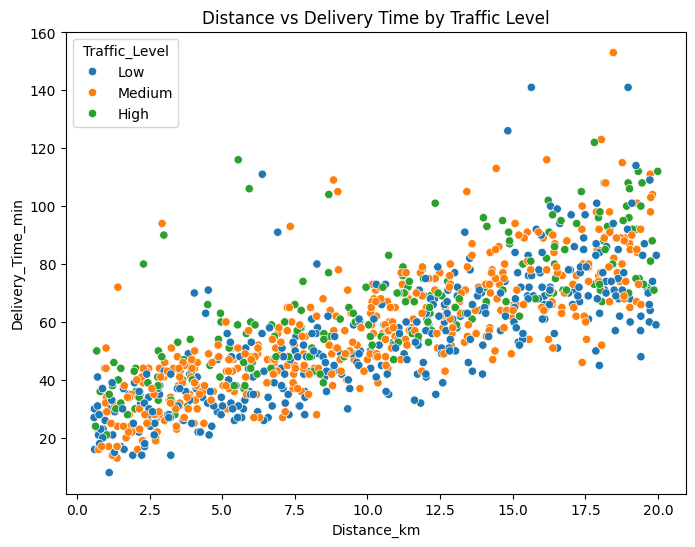

In [24]:
# ---- Scatterplot: Distance vs Delivery Time ----
plt.figure(figsize=(8,6))
sns.scatterplot(x="Distance_km", y="Delivery_Time_min", hue="Traffic_Level", data=df)
plt.title("Distance vs Delivery Time by Traffic Level")
plt.show()

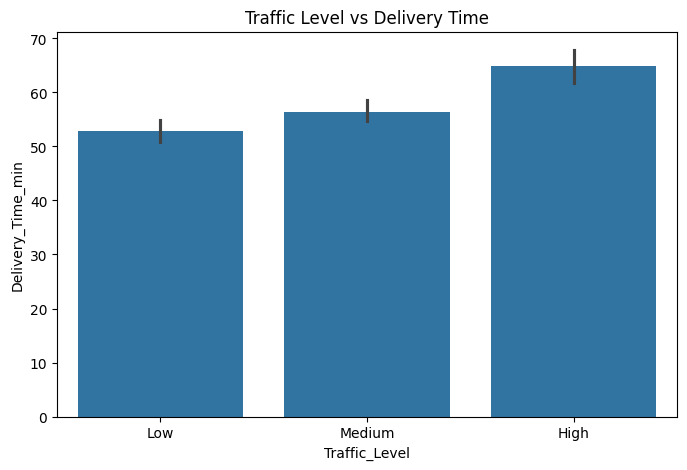

In [26]:
# ---- Barplot: Traffic vs Delivery Time ----
plt.figure(figsize=(8,5))
sns.barplot(x='Traffic_Level', y='Delivery_Time_min', data=df)
plt.title("Traffic Level vs Delivery Time")
plt.show()

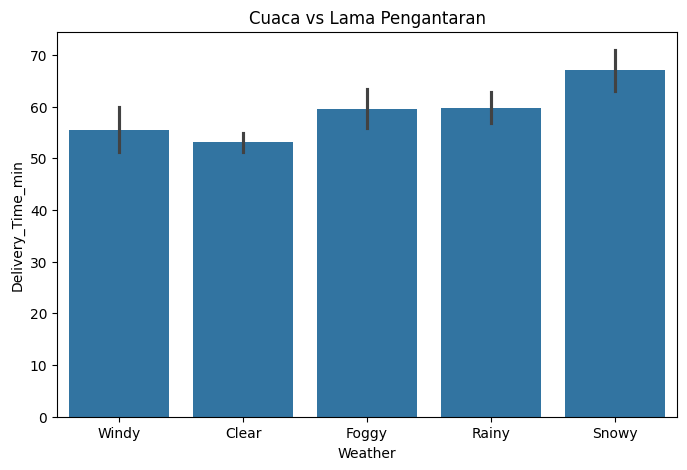

In [27]:
# ---- Barplot: Weather vs Delivery Time ----
plt.figure(figsize=(8,5))
sns.barplot(x='Weather', y='Delivery_Time_min', data=df)
plt.title("Cuaca vs Lama Pengantaran")
plt.show()

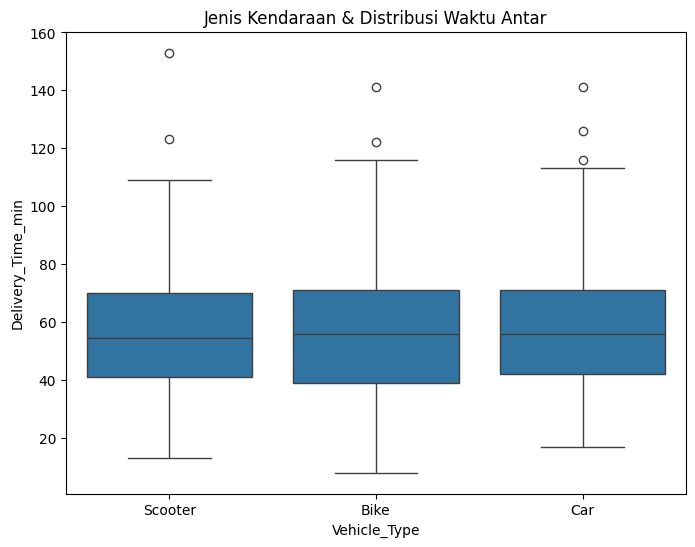

In [28]:
# ---- Vehicle Type Analysis ----
plt.figure(figsize=(8,6))
sns.boxplot(x='Vehicle_Type', y='Delivery_Time_min', data=df)
plt.title("Jenis Kendaraan & Distribusi Waktu Antar")
plt.show()

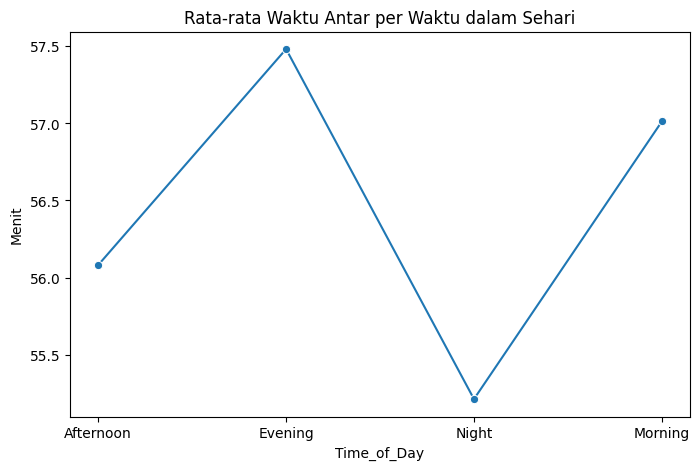

In [29]:
# ---- Time of Day Trend ----
plt.figure(figsize=(8,5))
sns.lineplot(x='Time_of_Day', y='Delivery_Time_min', data=df,
             estimator='mean', ci=None, marker='o')
plt.title("Rata-rata Waktu Antar per Waktu dalam Sehari")
plt.ylabel("Menit")
plt.show()

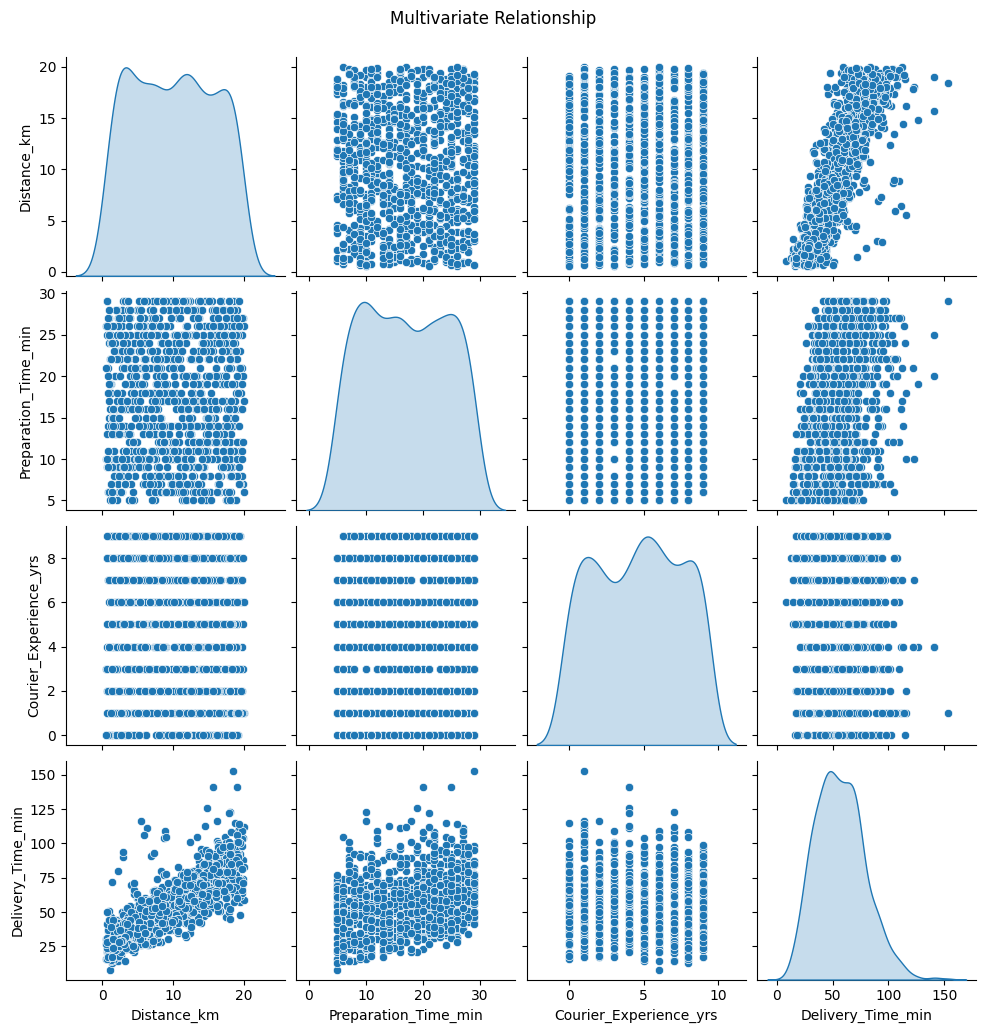

In [30]:
# ---- Pairplot untuk multivariate insight ----
sns.pairplot(df[['Distance_km','Preparation_Time_min','Courier_Experience_yrs',
                 'Delivery_Time_min']], diag_kind='kde')
plt.suptitle("Multivariate Relationship", y=1.03)
plt.show()

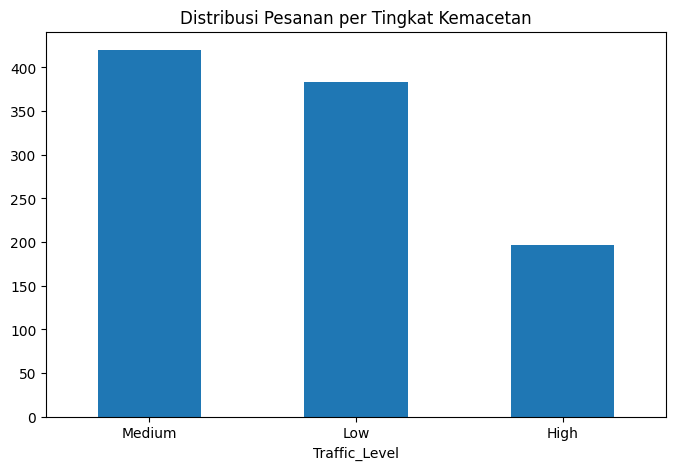

In [31]:
# ---- Insight kategori terhadap jumlah pesanan ----
plt.figure(figsize=(8,5))
df['Traffic_Level'].value_counts().plot(kind='bar', rot=0)
plt.title("Distribusi Pesanan per Tingkat Kemacetan")
plt.show()

In [32]:
# 🔧 5 — Preprocessing

X = df.drop(['Order_ID', 'Delivery_Time_min'], axis=1)
y = df['Delivery_Time_min']

# One-Hot Encoding untuk kolom kategori
categorical_features = X.select_dtypes(include='object').columns
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(drop='first'), categorical_features)],
    remainder='passthrough'
)
X = ct.fit_transform(X)

# Split Train-Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
# 🤖 6 — Model Training & Evaluation

def evaluate_model(model, name):
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    print(f"\n📌 {name} - Model Performance")
    print(f"MAE : {mae:.4f}")
    print(f"MSE : {mse:.4f}")
    print(f"R²  : {r2:.4f}")

    return mae, mse, r2

In [36]:
# 🔸 Model 1: Random Forest (Baseline)
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_scores = evaluate_model(rf, "Random Forest")

# 🔸 Model 2: Gradient Boosting Regressor
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
gbr_scores = evaluate_model(gbr, "Gradient Boosting")

# 🔸 Model 3: XGBoost Regressor
xgb_reg = xgb.XGBRegressor(eval_metric='mae')
xgb_reg.fit(X_train, y_train)
xgb_scores = evaluate_model(xgb_reg, "XGBoost")

# 🔸 Model 4: LightGBM Regressor
lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit(X_train, y_train)
lgb_scores = evaluate_model(lgb_reg, "LightGBM")


📌 Random Forest - Model Performance
MAE : 6.8878
MSE : 102.5914
R²  : 0.7951

📌 Gradient Boosting - Model Performance
MAE : 6.5689
MSE : 94.4471
R²  : 0.8114

📌 XGBoost - Model Performance
MAE : 7.7237
MSE : 123.5591
R²  : 0.7532
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 14
[LightGBM] [Info] Start training from score 57.304286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [37]:
# 🏆 7 — Model Comparison
# =========================================================
result_df = pd.DataFrame({
    "Model": ["Random Forest", "Gradient Boosting", "XGBoost", "LightGBM"],
    "MAE": [rf_scores[0], gbr_scores[0], xgb_scores[0], lgb_scores[0]],
    "MSE": [rf_scores[1], gbr_scores[1], xgb_scores[1], lgb_scores[1]],
    "R² Score": [rf_scores[2], gbr_scores[2], xgb_scores[2], lgb_scores[2]]
})

print("\n===============================")
print("📊 Perbandingan Kinerja Model")
print("===============================")
print(result_df)


📊 Perbandingan Kinerja Model
               Model       MAE         MSE  R² Score
0      Random Forest  6.887800  102.591427  0.795104
1  Gradient Boosting  6.568863   94.447106  0.811370
2            XGBoost  7.723729  123.559059  0.753227
3           LightGBM  6.993413   98.728096  0.802820


In [38]:
# =========================================================
# 🧪 A — Hyperparameter Tuning Semua Model
# =========================================================

print("\n===============================")
print("🔧 Hyperparameter Tuning")
print("===============================")

# -------------------------------
# 1️⃣ Gradient Boosting Tuning
# -------------------------------
gbr_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

gbr_grid = GridSearchCV(
    GradientBoostingRegressor(),
    gbr_params,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
gbr_grid.fit(X_train, y_train)

best_gbr = gbr_grid.best_estimator_
print("\n🔥 Best Gradient Boosting Params:", gbr_grid.best_params_)
evaluate_model(best_gbr, "Gradient Boosting (Tuned)")


# -------------------------------
# 2️⃣ Random Forest Tuning
# -------------------------------
from sklearn.ensemble import RandomForestRegressor

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(),
    rf_params,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
print("\n🌲 Best Random Forest Params:", rf_grid.best_params_)
evaluate_model(best_rf, "Random Forest (Tuned)")


# -------------------------------
# 3️⃣ XGBoost Tuning
# -------------------------------
xgb_params = {
    'n_estimators': [200, 300],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1]
}

xgb_grid = GridSearchCV(
    xgb.XGBRegressor(eval_metric='mae'),
    xgb_params,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_
print("\n⚡ Best XGBoost Params:", xgb_grid.best_params_)
evaluate_model(best_xgb, "XGBoost (Tuned)")


# -------------------------------
# 4️⃣ LightGBM Tuning
# -------------------------------
lgb_params = {
    'n_estimators': [200, 300],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50]
}

lgb_grid = GridSearchCV(
    lgb.LGBMRegressor(),
    lgb_params,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
lgb_grid.fit(X_train, y_train)

best_lgb = lgb_grid.best_estimator_
print("\n⚡ Best LightGBM Params:", lgb_grid.best_params_)
evaluate_model(best_lgb, "LightGBM (Tuned)")


🔧 Hyperparameter Tuning

🔥 Best Gradient Boosting Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

📌 Gradient Boosting (Tuned) - Model Performance
MAE : 6.7950
MSE : 97.9803
R²  : 0.8043

🌲 Best Random Forest Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}

📌 Random Forest (Tuned) - Model Performance
MAE : 6.9403
MSE : 104.9038
R²  : 0.7905

⚡ Best XGBoost Params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}

📌 XGBoost (Tuned) - Model Performance
MAE : 6.4235
MSE : 92.4942
R²  : 0.8153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 14
[LightGBM] [Info] Start training from score 57.304286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

(6.986201516601723, 100.26979586228849, 0.7997405001123881)

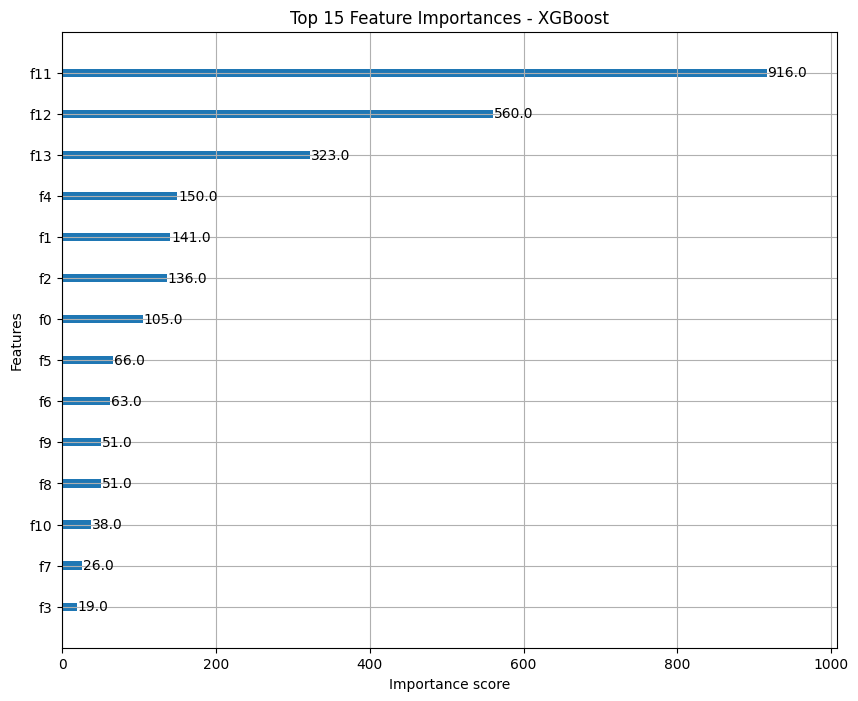

In [40]:
from xgboost import plot_importance
# Feature Importance dari XGBoost
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(best_xgb, ax=ax, max_num_features=15)
plt.title("Top 15 Feature Importances - XGBoost")
plt.show()

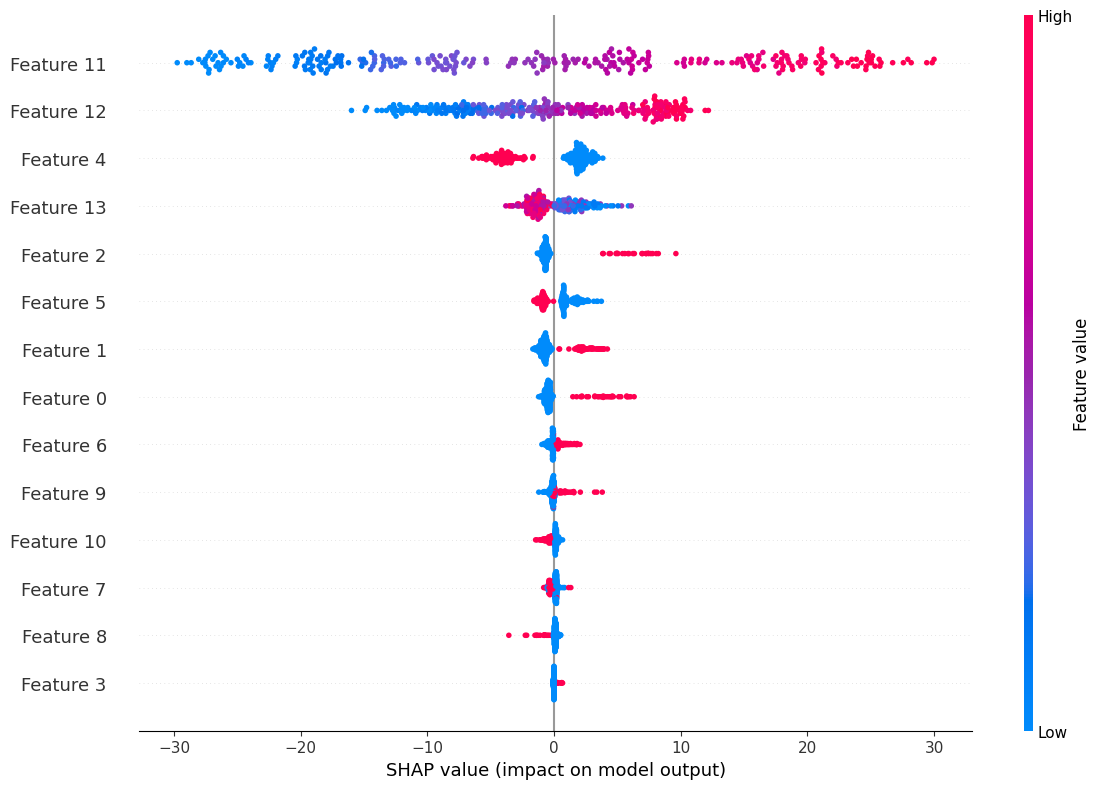

In [41]:
import shap

# SHAP untuk XGBoost
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test, plot_size=(12,8))

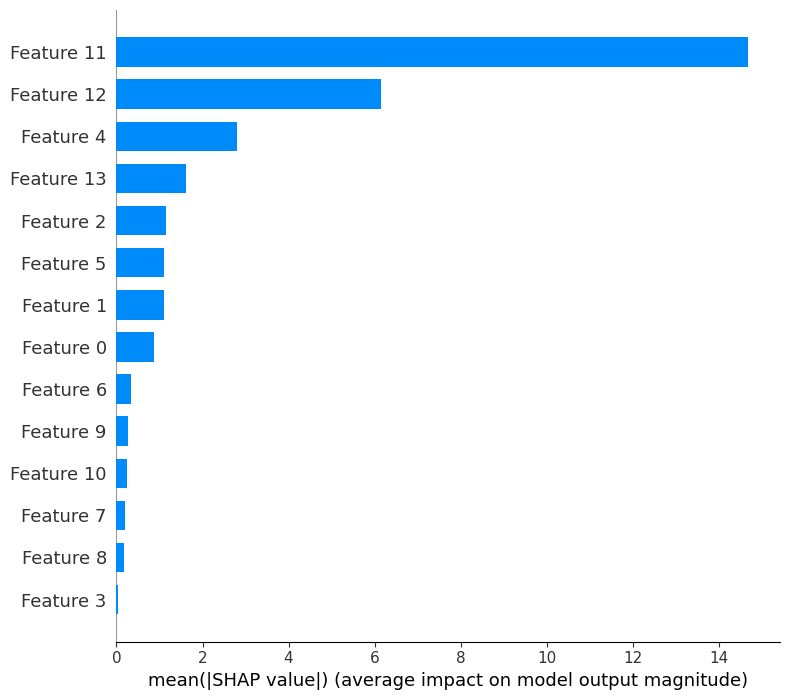

In [42]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [43]:
# Contoh sample pertama
sample_idx = 0
shap.force_plot(explainer.expected_value, 
                shap_values[sample_idx], 
                X_test.iloc[sample_idx])


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [46]:
import joblib

joblib.dump(xgb_reg, "xgboost_delivery_model.pkl")
print("Model berhasil disimpan!")

Model berhasil disimpan!


In [47]:
joblib.dump(ct, "ohe_encoder.pkl")
print("Encoder berhasil disimpan!")

Encoder berhasil disimpan!
